In [1]:
from typing import Final

import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, execute
from qiskit.circuit import Qubit
from qiskit.providers import Backend
from qiskit.tools.monitor import job_monitor

In [7]:
NUM_SITES: Final[int] = 4

In [9]:
# Bogoliubov transformation


def thetak(k: int, lambda_: float) -> float:
    angle = 2 * np.pi * k / NUM_SITES
    x = np.cos(angle)
    y = np.sin(angle)

    return np.arccos((lambda_ - x) / np.sqrt((lambda_ - x) ** 2 + y**2))


def bogo(qc: QuantumCircuit, qubits: list[Qubit], theta: float) -> None:
    qc.x(qubits[1])
    qc.cx(qubits[1], qubits[0])
    qc.crx(theta, qubits[0], qubits[1])
    qc.cx(qubits[1], qubits[0])
    qc.x(qubits[1])

In [10]:
# Fourier transformation


def fourier(qc: QuantumCircuit, qubits: list[Qubit], k: int) -> None:
    qc.cx(qubits[0], qubits[1])
    qc.ch(qubits[1], qubits[0])
    qc.cx(qubits[0], qubits[1])
    qc.cz(qubits[0], qubits[1])
    qc.p(2 * np.pi * k / NUM_SITES, qubits[0])

In [ ]:
def digit_sum(n: int) -> int:
    num_str = str(n)
    sum = 0
    for i in range(0, len(num_str)):
        sum += int(num_str[i])
    return sum

In [ ]:
def disentangle(qc: QuantumCircuit, lambda_: float) -> None:
    bogo(qc, qc.qubits[0:2], thetak(1, lambda_))

    fourier(qc, qc.qubits[0:2], 1)
    fourier(qc, qc.qubits[2:4], 0)

    fourier(qc, qc.qubits[0:2], 0)
    fourier(qc, qc.qubits[2:4], 0)

In [11]:
def executeJobAndGetMagnetization(
    qc: QuantumCircuit, backend: Backend, shots: int, max_credits: int
) -> list[float]:
    # magnetization
    mag = []
    job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(qc)

    r1 = list(counts.keys())
    r2 = list(counts.values())
    M = 0
    for j in range(0, len(r1)):
        M = M + (4 - 2 * digit_sum(r1[j])) * r2[j] / shots

    mag.append(M / 4)
    return mag

In [ ]:
# TODO: Why is this a list[float]?

def initialize(lambda_: float, backend: Backend) -> list[float]:
    qc = QuantumCircuit(NUM_SITES, NUM_SITES)
    if lambda_ < 1:
        qc.x(NUM_SITES - 1)
        qc.barrier()

    disentangle(qc, lambda_)

    for i in range(0, NUM_SITES):
        qc.measure(i, i)

    return executeJobAndGetMagnetization(qc, backend, 1024, 10)

In [25]:
from qiskit_ibm_provider import IBMProvider

# IBMProvider.save_account(TOKEN)

provider = IBMProvider()
provider.backends()

[<IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_brisbane')>]

In [26]:
simulator = provider.get_backend("ibmq_qasm_simulator")
computer = provider.get_backend("ibm_nairobi")

Job Status: job has successfully run


c:\Users\davis\OneDrive - Colorado School of Mines\1 Fall 2023\PHGN 519 Fundamentals of Quantum Information\project-1\ising-model\.venv\Lib\site-packages\qiskit\utils\deprecation.py:182: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return func(*args, **kwargs)


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


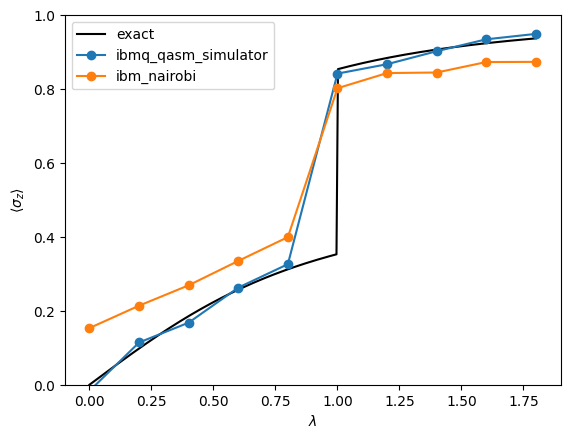

In [33]:
def exact(lambda_: float) -> float:
    magnetization = lambda_ / (2 * np.sqrt(1 + lambda_**2))
    if lambda_ < 1:
        return magnetization
    if lambda_ > 1:
        return magnetization + 0.5
    return np.nan


vexact = np.vectorize(exact)

lambdas = np.linspace(0, 1.8, 10)
more_lambdas = np.linspace(0, 1.8, 301)

sim_magnetization, real_magnetization = [], []
for l in lambdas:
    sim_magnetization.append(initialize(l, simulator))
    real_magnetization.append(initialize(l, computer))

plt.plot(more_lambdas, vexact(more_lambdas), color="black", label="exact")
plt.plot(lambdas, sim_magnetization, marker="o", label=simulator.name)
plt.plot(lambdas, real_magnetization, marker="o", label=computer.name)
plt.ylabel("$\\langle\\sigma_z\\rangle$")
plt.xlabel("$\\lambda$")
plt.ylim(0, 1)
plt.xlim(-0.1, max(lambdas) + 0.1)
plt.legend()

In [14]:
def wire(lambda_):
    qc = QuantumCircuit(NUM_SITES, NUM_SITES)
    if lambda_ < 1:
        qc.x(3)
        qc.barrier()

    return qc


def time_evol(time, lambda_, backend, circuit):
    # This line seems to do everything time related for the transform
    circuit.u(
        np.arccos(lambda_ / np.sqrt(1 + lambda_**2)),
        np.pi / 2 + 4 * time * np.sqrt(1 + lambda_**2),
        0,
        0,
    )
    circuit.cx(0, 1)

    mag = []

    disentangle(circuit, lambda_)

    for i in range(0, 4):
        circuit.measure(i, i)

    shots = 1024
    max_credits = 10
    job = execute(circuit, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(circuit)

    r1 = list(counts.keys())
    r2 = list(counts.values())
    M = 0
    for j in range(0, len(r1)):
        M = M + (4 - 2 * digit_sum(r1[j])) * r2[j] / shots

    mag.append(M / 4)
    return mag

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


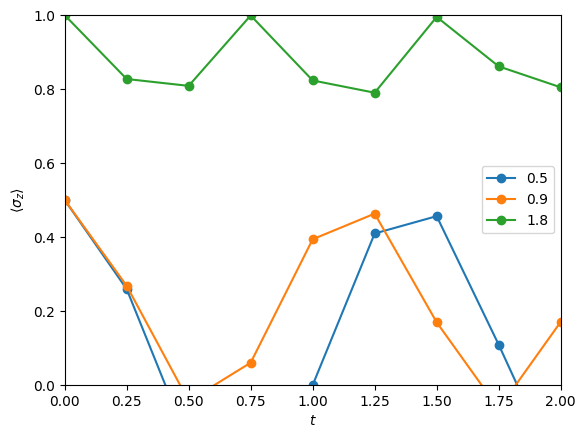

In [15]:
lambdas = [0.5, 0.9, 1.8]
times = np.linspace(0, 2, 9)

fig, ax = plt.subplots()
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)
ax.set_xlabel("$t$")
ax.set_ylabel("$\\langle\\sigma_z\\rangle$")

for l in lambdas:
    mag = []
    for t in times:
        mag.append(time_evol(t, l, backend, wire(l)))

    ax.plot(times, mag, linestyle="-", marker="o", label=l)

ax.legend()

plt.show()

In [16]:
from qiskit_ibm_provider.version import __version__

print("qiskit-ibm-provider version: {}".format(__version__))

qiskit-ibm-provider version: 0.7.0


In [17]:
import qiskit.tools.jupyter

%qiskit_version_table